In [2]:
def tracking_levels(prices):
    first_support_zone = 100
    first_resistance_zone = 120
    second_support_zone = None
    first_resistance_as_support_zone = None
    first_support_as_resistance_zone = None

    for i in prices:
        print(f"Price: {i}")
        if i < first_support_zone and second_support_zone is None:
            second_support_zone = i
            first_support_as_resistance_zone = first_support_zone
            print(f"Support Zone is broken! New Support zone-S2: {second_support_zone}, S1 {first_support_zone} is now resistance.")
        elif  first_support_as_resistance_zone and second_support_zone and i >= second_support_zone and i <= first_support_as_resistance_zone:
            print(f"Price between S2 {second_support_zone} and new resistance {first_support_as_resistance_zone}")
            
        elif i > first_resistance_zone:
            first_resistance_as_support_zone = first_resistance_zone
            print(f"Resistance Zone is broken! R1 {first_resistance_zone} is now support.")
            break
            
        elif first_support_zone <= i <= first_resistance_zone:
            print(f"Price between S1 {first_support_zone} and R1 {first_resistance_zone}.")

    return {
        "S1 (original support)": first_support_zone,
        "R1 (original resistance)": first_resistance_zone,
        "S2 (new_support)": second_support_zone,
        "New resistance old-S1": first_support_as_resistance_zone,
        "New support old-R1": first_resistance_as_support_zone
    }

price_data = [110, 105, 98, 102, 115, 125, 118]
result = tracking_levels(price_data)
print("\nFinal Levels:")
for key, value in result.items():
    print(f"{key}: {value}")

Price: 110
Price between S1 100 and R1 120.
Price: 105
Price between S1 100 and R1 120.
Price: 98
Support Zone is broken! New Support zone-S2: 98, S1 100 is now resistance.
Price: 102
Price between S1 100 and R1 120.
Price: 115
Price between S1 100 and R1 120.
Price: 125
Resistance Zone is broken! R1 120 is now support.

Final Levels:
S1 (original support): 100
R1 (original resistance): 120
S2 (new_support): 98
New resistance old-S1: 100
New support old-R1: 120


In [3]:
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt


In [4]:
input_data = pd.read_csv("INFY-EQ-24-02-2024-to-24-02-2025.csv", encoding="utf-8")
input_data.rename(columns=lambda x: x.strip(), inplace=True)

if 'Date' not in input_data.columns:
    raise KeyError("The 'Date' column is missing. Check column names in the CSV.")

input_data["Date"] = pd.to_datetime(input_data["Date"].astype(str).str.strip(), format="%d-%b-%y", errors='coerce')
input_data = input_data.dropna(subset=["Date"])
input_data = input_data.sort_values(by="Date")

input_data["Close"] = input_data["Close"].astype(str).str.replace(",", "").astype(float)
input_data = input_data.reset_index(drop=True)

print("Checking 2024-09-11:")
print(input_data[input_data["Date"] == pd.Timestamp("2024-09-11")][["Date", "Close"]])

close_price_data = input_data["Close"].values

input_data["SMA_10"] = talib.SMA(close_price_data, timeperiod=10)
input_data["EMA_50"] = talib.EMA(close_price_data, timeperiod=50)
input_data["RSI_14"] = talib.RSI(close_price_data, timeperiod = 14)
macd, macdsignal, macdhist = talib.MACD(close_price_data, fastperiod=12, slowperiod=26, signalperiod=9)
input_data["MACD"] = macd
input_data["MACD_SIGNAL"] = macdsignal
input_data["MACD_HIST"] = macdhist

latest_ema = input_data["EMA_50"].dropna()
latest_sma = input_data["SMA_10"].dropna()
latest_rsi = input_data["RSI_14"].dropna()
latest_macd = input_data["MACD"].dropna()
latest_macdsignal = input_data["MACD_SIGNAL"].dropna()
latest_macdhist = input_data["MACD_HIST"].dropna()

latest_close_price = input_data["Close"].iloc[-1]

input_data.to_csv("EMA_50_Values.csv", index=False)
input_data.to_csv("SMA_10_Values.csv", index=False)
input_data.to_csv("RSI_14_Values.csv", index = False)
input_data.to_csv("MACD_Values.csv", index=False)

print("Current Price:", latest_close_price)
print("Close_price_Length:", len(close_price_data))
print("Latest EMA Length:", len(latest_ema))
print("Latest SMA Length:", len(latest_sma))
print("Latest RSI Length:", len(latest_rsi))
print("MACD Values Length:", len(latest_macd))
print("MACD Signals Length:", len(latest_macdsignal))
print("MACD Hist Length:", len(latest_macdhist))



Checking 2024-09-11:
          Date    Close
134 2024-09-11  1910.15
Current Price: 1815.0
Close_price_Length: 249
Latest EMA Length: 200
Latest SMA Length: 240
Latest RSI Length: 235
MACD Values Length: 216
MACD Signals Length: 216
MACD Hist Length: 216


In [5]:
def find_swing_points(data, window=5, tolerance=0.5):
    
    support_levels = []
    resistance_levels = []
    support_to_resistance = []
    resistance_to_support = []
    
    for i in range(window, len(data) - window):
        current_price = data["Close"].iloc[i]
        window_before = data["Close"].iloc[i - window:i]
        window_after = data["Close"].iloc[i + 1:i + window + 1]

        if current_price < min(window_before) and current_price < min(window_after):
            support_levels.append((data["Date"].iloc[i], current_price))
            
        if current_price > max(window_before) and current_price > max(window_after):
            resistance_levels.append((data["Date"].iloc[i], current_price))

    all_levels = support_levels + resistance_levels
    all_levels.sort(key=lambda x: x[0]) 
    
    final_support_levels = []
    final_resistance_levels = []
    
    for i in range(len(data)):
        current_price = data["Close"].iloc[i]
        current_date = data["Date"].iloc[i]
        
        for level_date, level_price in all_levels:
            price_diff = abs(current_price - level_price)
            tolerance_range = level_price * (tolerance / 100)
            
            if price_diff <= tolerance_range and level_date < current_date:
                if (level_date, level_price) in support_levels:
                    if current_price <= level_price:
                        support_to_resistance.append((current_date, current_price))
                        final_resistance_levels.append((current_date, current_price))
                
                elif (level_date, level_price) in resistance_levels:
                    if current_price >= level_price:
                        resistance_to_support.append((current_date, current_price))
                        final_support_levels.append((current_date, current_price))
                        
    final_support_levels = list(set(support_levels + resistance_to_support))
    final_resistance_levels = list(set(resistance_levels + support_to_resistance))
    final_support_levels.sort(key=lambda x: x[0])
    final_resistance_levels.sort(key=lambda x: x[0])
    
    return {
        'initial_support': support_levels,
        'initial_resistance': resistance_levels,
        'support_to_resistance': support_to_resistance,
        'resistance_to_support': resistance_to_support,
        'final_support': final_support_levels,
        'final_resistance': final_resistance_levels
    }

levels = find_swing_points(input_data, window=5, tolerance=0.5)
 
print("\nInitial Support Levels:", len(levels['initial_support']))
for date, price in levels['initial_support']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\nInitial Resistance Levels:", len(levels['initial_resistance']))
for date, price in levels['initial_resistance']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\nSupport Levels Converted to Resistance:", len(levels['support_to_resistance']))
for date, price in levels['support_to_resistance']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\nResistance Levels Converted to Support:", len(levels['resistance_to_support']))
for date, price in levels['resistance_to_support']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\nFinal Support Levels:", len(levels['final_support']))
for date, price in levels['final_support']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\nFinal Resistance Levels:", len(levels['final_resistance']))
for date, price in levels['final_resistance']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")



Initial Support Levels: 14
Date: 2024-03-11, Price: 1600.6
Date: 2024-04-19, Price: 1411.25
Date: 2024-05-02, Price: 1414.45
Date: 2024-05-15, Price: 1419.95
Date: 2024-06-04, Price: 1393.65
Date: 2024-08-08, Price: 1743.15
Date: 2024-09-09, Price: 1894.65
Date: 2024-09-18, Price: 1892.15
Date: 2024-09-30, Price: 1875.6
Date: 2024-11-05, Price: 1754.2
Date: 2024-11-18, Price: 1811.45
Date: 2024-12-31, Price: 1880.0
Date: 2025-01-09, Price: 1917.3
Date: 2025-01-21, Price: 1800.7

Initial Resistance Levels: 15
Date: 2024-03-14, Price: 1653.3
Date: 2024-04-10, Price: 1506.8
Date: 2024-05-07, Price: 1440.95
Date: 2024-05-23, Price: 1472.4
Date: 2024-06-07, Price: 1533.6
Date: 2024-07-26, Price: 1878.9
Date: 2024-09-02, Price: 1964.5
Date: 2024-09-17, Price: 1952.55
Date: 2024-10-17, Price: 1968.1
Date: 2024-11-12, Price: 1868.8
Date: 2024-11-27, Price: 1924.5
Date: 2024-12-13, Price: 1999.7
Date: 2025-01-02, Price: 1957.85
Date: 2025-01-10, Price: 1966.95
Date: 2025-02-06, Price: 1915.65


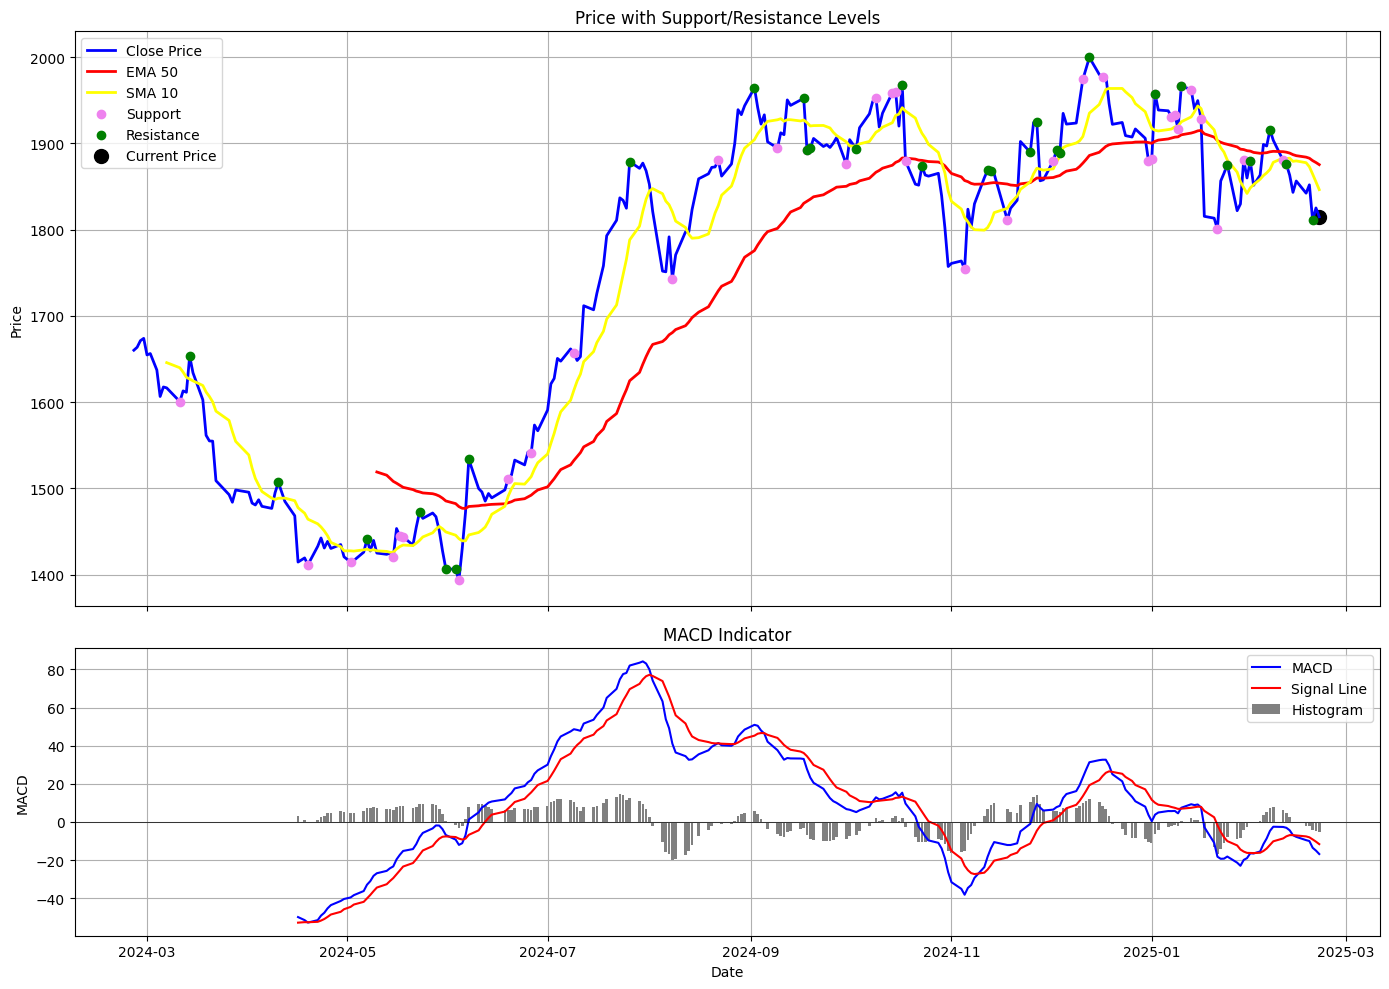

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[2, 1], sharex=True)

ax1.plot(input_data["Date"], input_data["Close"], label="Close Price", color="blue", linewidth=2)
ax1.plot(input_data["Date"], input_data["EMA_50"], label="EMA 50", color="red", linewidth=2)
ax1.plot(input_data["Date"], input_data["SMA_10"], label="SMA 10", color="yellow", linewidth=2)

support_dates, support_prices = zip(*levels['final_support'])
resistance_dates, resistance_prices = zip(*levels['final_resistance'])

ax1.scatter(support_dates, support_prices, color='violet', label='Support', zorder=5)
ax1.scatter(resistance_dates, resistance_prices, color='green', label='Resistance', zorder=5)
ax1.scatter(input_data["Date"].iloc[-1], input_data["Close"].iloc[-1], label="Current Price", color="black", s=100)
ax1.set_ylabel("Price")
ax1.set_title("Price with Support/Resistance Levels")
ax1.legend()
ax1.grid()

ax2.plot(input_data["Date"], input_data["MACD"], label="MACD", color="blue", linewidth=1.5)
ax2.plot(input_data["Date"], input_data["MACD_SIGNAL"], label="Signal Line", color="red", linewidth=1.5)
ax2.bar(input_data["Date"], input_data["MACD_HIST"], label="Histogram", color="gray", alpha=1)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel("Date")
ax2.set_ylabel("MACD")
ax2.set_title("MACD Indicator")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()